# Laboratorio 7
**Rodrigo Mansilla**

**Brandon Reyes**

## Inicialización de Librerias

In [33]:
# Librerías principales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# AutoML
from autogluon.tabular import TabularPredictor

# Configuración de estilo de gráficos
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 5)


## Carga del Dataset

In [ ]:

df = pd.read_csv("diabetes.csv")

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



### Variables del dataset (`diabetes.csv`):

- **Pregnancies**: Número de veces que la paciente ha estado embarazada.  
- **BloodPressure**: Presión arterial diastólica (mm Hg).  
- **Skin**: Grosor del pliegue cutáneo del tríceps (mm).  
- **Insulin**: Nivel de insulina sérica a las 2 horas (mu U/ml).  
- **BMI**: Índice de masa corporal (peso en kg / altura en m²).  
- **DiabetesPedigreeFunction**: Función de historial familiar de diabetes (mide predisposición hereditaria).  
- **Age**: Edad de la persona (en años).  
- **Outcome**: Variable objetivo.  
  - `0`: El paciente **no presenta diabetes**.  
  - `1`: El paciente **presenta diabetes**.  

### Contexto
El dataset busca predecir la presencia de **diabetes tipo II** en función de variables clínicas y características personales.  
La columna **Outcome** es el objetivo de clasificación binaria:  
- **0 = No diabetes**,  
- **1 = Con diabetes**.  



## Análisis Exploratorio de Datos (EDA):


Se realiza un análisis exploratorio para comprender mejor las características del dataset:  
1. Estadísticas descriptivas.  
2. Distribuciones de las variables (histogramas y boxplots).  
3. Presencia de valores nulos y atípicos.  
4. Balance de clases de la variable *Outcome*.  
5. Correlaciones entre variables y mapa de calor.  

### 1. Estadísticas descriptivas 


In [6]:
print("Dimensiones del dataset:", df.shape)
display(df.describe())

Dimensiones del dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- El dataset contiene **768 registros**.  
- Variables como **Glucose, BloodPressure, SkinThickness, Insulin y BMI** presentan valores mínimos de **0**, que no son fisiológicamente válidos.  
- La media de **Glucose** (~121) y de **BMI** (~32) reflejan una población con riesgo metabólico elevado.  
- **Insulin** muestra  dispersión (máximo 846, std ~115), indicando presencia de outliers.


### 2. Distribuciones con histogramas

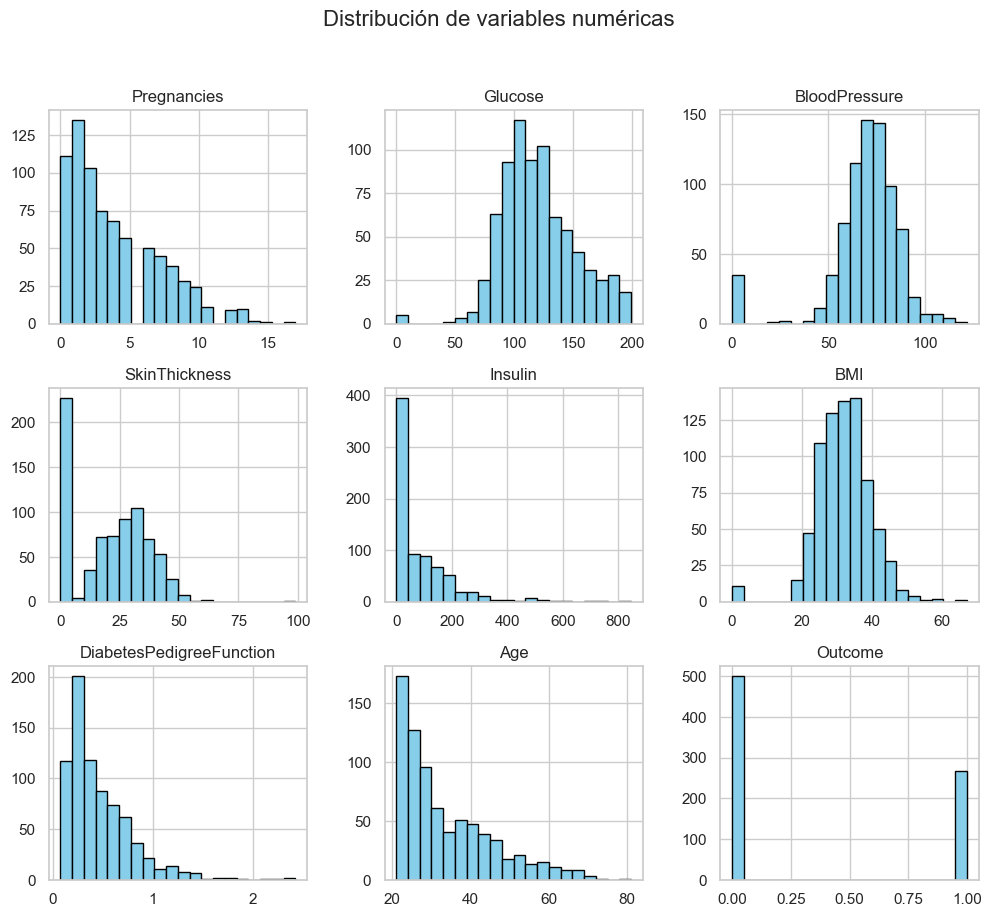

In [7]:
df.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

- **Glucose** tiene una distribución aproximadamente normal centrada en ~120.  
- **BloodPressure** es simétrica alrededor de 70 mmHg.  
- **SkinThickness** e **Insulin** presentan fuerte sesgo hacia valores bajos, con muchos ceros.  
- **BMI** se concentra en 25–40 (predominio de sobrepeso/obesidad).  
- **Pregnancies** y **Age** muestran distribuciones asimétricas a la izquierda .  


### 3.Detección de outliers

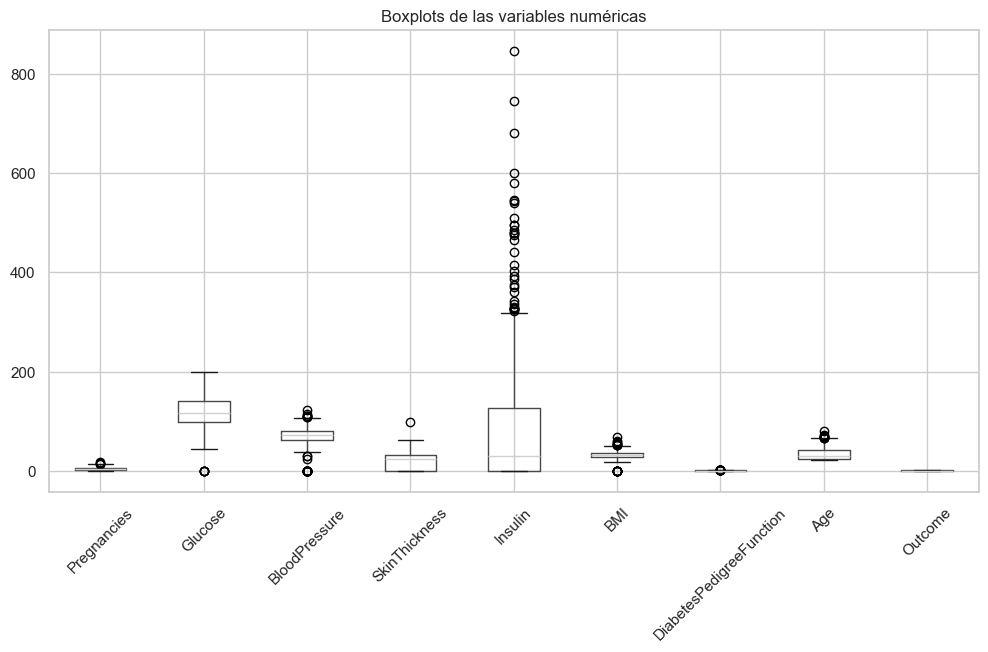

In [ ]:
df.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

- Se identifican **outliers extremos**, principalmente en **Insulin** y en menor grado en **SkinThickness** y **Glucose**.  
- La mayoría de variables tienen rango intercuartílico estable, salvo **Insulin** que presenta alta variabilidad.  


### 3. Valores nulos

In [9]:
print("\nValores nulos en el dataset:")
print(df.isnull().sum())



Valores nulos en el dataset:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [15]:
import numpy as np

cols_with_zero_invalid = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

print("\nCantidad de ceros en variables críticas:")
print((df[cols_with_zero_invalid] == 0).sum())

df_clean = df.copy()
df_clean[cols_with_zero_invalid] = df_clean[cols_with_zero_invalid].replace(0, np.nan)

print("\nValores faltantes después de reemplazo de ceros:")
print(df_clean.isnull().sum())

df_imputed = df_clean.fillna(df_clean.median(numeric_only=True))


Cantidad de ceros en variables críticas:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Valores faltantes después de reemplazo de ceros:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


- No existen valores `NaN` explícitos, pero sí **ceros inválidos**:  
  - 374 en **Insulin**  
  - 227 en **SkinThickness**  
  - 35 en **BloodPressure**  
  - 11 en **BMI**  
  - 5 en **Glucose**  
- Estos ceros deben tratarse como *missing values* e imputarse  o dejar que AutoGluon los maneje automáticamente.  


### 4. Balance de clases

C:\Users\rodri\AppData\Local\Temp\ipykernel_27256\4063261591.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=df, palette="pastel")


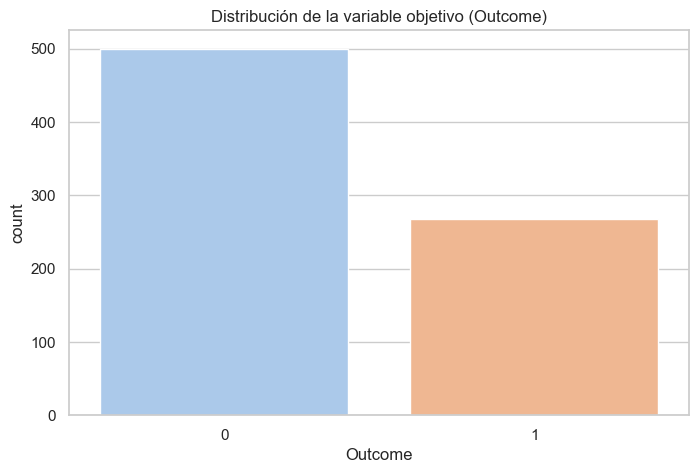


Balance de clases:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [12]:
sns.countplot(x="Outcome", data=df, palette="pastel")
plt.title("Distribución de la variable objetivo (Outcome)")
plt.show()

print("\nBalance de clases:")
print(df["Outcome"].value_counts(normalize=True))

- El dataset está **desbalanceado**:  
  - `0` (no diabetes): ~65%  
  - `1` (diabetes): ~35%  


### 5. Correlación y mapa de calor

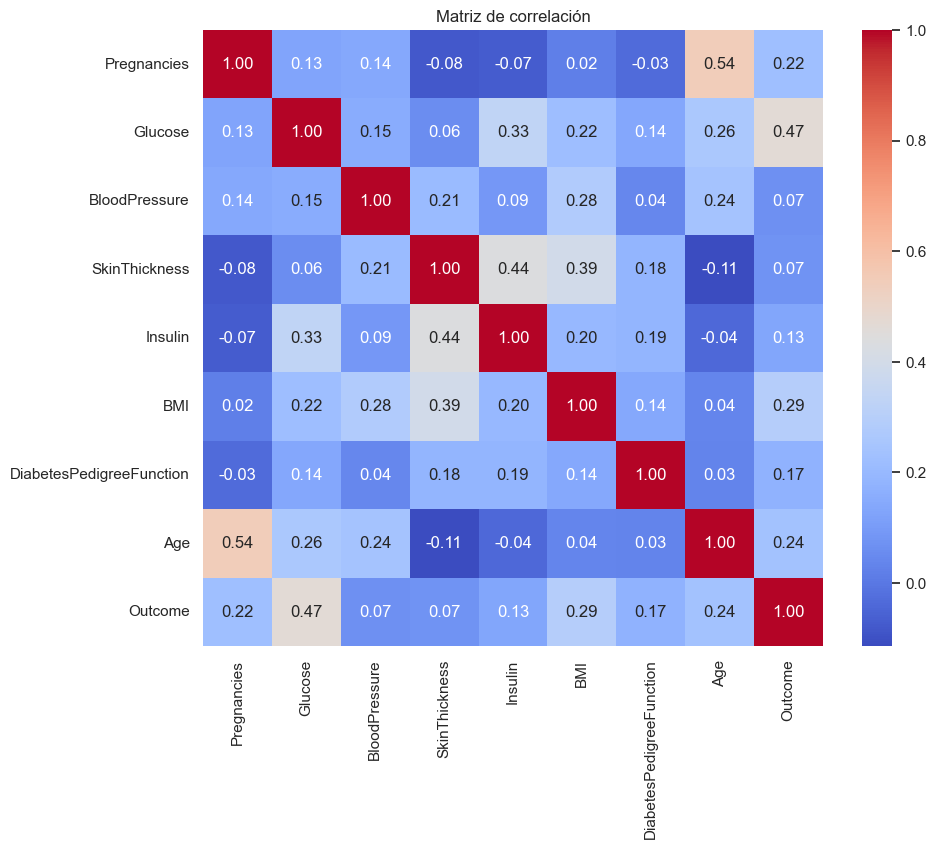

In [13]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlación")
plt.show()

- **Glucose** es la variable más correlacionada con `Outcome` .  
- **BMI**, **Age** y **Pregnancies** también muestran correlaciones positivas relevantes.  
- **Insulin** y **SkinThickness** presentan correlaciones moderadas pero con alta proporción de valores faltantes.  
- No se observan correlaciones muy altas entre variables independientes → baja multicolinealidad.


## Preprocesamiento

De acuerdo con el análisis exploratorio:
- Se identificaron ceros inválidos en variables fisiológicas, tratados como valores faltantes.
- Se imputaron estos valores con la **mediana** de cada columna.
- Se generó un nuevo dataset `df_prepared` listo para entrenamiento con AutoGluon.

In [ ]:
import numpy as np

df_prepared = df.copy()

cols_with_zero_invalid = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df_prepared[cols_with_zero_invalid] = df_prepared[cols_with_zero_invalid].replace(0, np.nan)

df_prepared = df_prepared.fillna(df_prepared.median(numeric_only=True))

print("Valores faltantes después del preprocesamiento:")
print(df_prepared.isnull().sum())

# Vista inicial
df_prepared.head()


Valores faltantes después del preprocesamiento:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## Entrenamiento del modelo con AutoGluon

### Separación en Train/Test

In [20]:
train_data, test_data = train_test_split(df_prepared, test_size=0.3, random_state=42, stratify=df_prepared["Outcome"])

print("Tamaño entrenamiento:", train_data.shape)
print("Tamaño prueba:", test_data.shape)

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)
# Define la columna objetivo
columna_objetivo = "Outcome"

Tamaño entrenamiento: (537, 9)
Tamaño prueba: (231, 9)


### Entrenamiento

In [28]:
label = "Outcome"
train_df, test_df = train_test_split(
    df_prepared, test_size=0.30, random_state=42, stratify=df_prepared[label]
)

train_data = TabularDataset(train_df)
test_data  = TabularDataset(test_df)

# 3) Conjunto de modelos a entrenar
hyperparams = {
    "GBM": {},          # LightGBM
    "CAT": {},          # CatBoost
    "XGB": {},          # XGBoost
    "RF": {},           # RandomForest
    "XT": {},           # ExtraTrees
    "KNN": {},          # kNN
    "NN_TORCH": {},     # Red neuronal (PyTorch)
    "LR": {},           # Lineal (Logistic/SGD)
}

predictor = TabularPredictor(
    label=label,
    problem_type="binary",
    eval_metric="accuracy",
).fit(
    train_data=train_data,
    presets="best_quality",
    time_limit=800,    
    hyperparameters=hyperparams,
    verbosity=2,
)
predictor = TabularPredictor(
    label=label,
    problem_type="binary",
    eval_metric="accuracy",
).fit(
    train_data=train_data,
    presets="best_quality",
    time_limit=2500,      
    hyperparameters=hyperparams,
    verbosity=2,
)

# 5) Desempeño de modelos 
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard)

model_names = leaderboard["model"].tolist()
print("Modelos entrenados:", model_names)

No path specified. Models will be saved in: "AutogluonModels\ag-20250929_030411"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       1.86 GB / 11.78 GB (15.8%)
Disk Space Avail:   177.44 GB / 475.67 GB (37.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.753247,0.800745,accuracy,1.665514,0.728731,4.151892,0.033927,0.000996,0.071288,3,True,9
1,ExtraTrees_BAG_L1,0.748918,0.789572,accuracy,0.203488,0.204077,1.250707,0.203488,0.204077,1.250707,1,True,3
2,WeightedEnsemble_L2,0.748918,0.789572,accuracy,0.237428,0.206102,1.342056,0.033940,0.002025,0.091349,2,True,5
3,LinearModel_BAG_L2,0.748918,0.797020,accuracy,1.631587,0.727735,4.080604,0.538476,0.148170,0.930556,2,True,8
4,RandomForest_BAG_L1,0.740260,0.759777,accuracy,0.224081,0.199665,1.372028,0.224081,0.199665,1.372028,1,True,2
5,ExtraTrees_BAG_L2,0.740260,0.782123,accuracy,1.285525,0.808797,4.505553,0.192414,0.229232,1.355506,2,True,7
6,LinearModel_BAG_L1,0.735931,0.767225,accuracy,0.545752,0.083755,0.512750,0.545752,0.083755,0.512750,1,True,4
7,RandomForest_BAG_L2,0.735931,0.778399,accuracy,1.292126,1.200939,4.587759,0.199015,0.621374,1.437712,2,True,6
8,KNeighbors_BAG_L1,0.696970,0.720670,accuracy,0.119790,0.092068,0.014562,0.119790,0.092068,0.014562,1,True,1


Modelos entrenados: ['WeightedEnsemble_L3', 'ExtraTrees_BAG_L1', 'WeightedEnsemble_L2', 'LinearModel_BAG_L2', 'RandomForest_BAG_L1', 'ExtraTrees_BAG_L2', 'LinearModel_BAG_L1', 'RandomForest_BAG_L2', 'KNeighbors_BAG_L1']


- El **mejor modelo fue el ensamble de nivel 3 (WeightedEnsemble_L3)** con **accuracy de 0.753 en test** y 0.801 en validación.  
- Los modelos base como **ExtraTrees y RandomForest** lograron entre 0.735–0.749 de accuracy, lo cual es competitivo pero menor al ensamble.  
- **KNeighbors** obtuvo el peor desempeño (0.697), confirmando que técnicas basadas en distancia son menos efectivas en este dataset con alta dimensionalidad y escalas heterogéneas.  
- Los **modelos lineales** tuvieron desempeño intermedio (~0.736–0.749), lo esperado en datasets donde las relaciones no son completamente lineales.  


### Baseline vs Modelos


In [29]:
# BASELINE 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = train_data.drop(columns=[label])
y_train = train_data[label]
X_test  = test_data.drop(columns=[label])
y_test  = test_data[label]

# Regresión Logística 
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# Mejor modelo de AutoGluon 
y_pred_ag = predictor.predict(test_data)
acc_ag = accuracy_score(y_test, y_pred_ag)

print(f"Accuracy — Baseline (LogisticRegression): {acc_lr:.4f}")
print(f"Accuracy — AutoGluon (mejor ensamble/modelo): {acc_ag:.4f}")
print(f"Diferencia (AG - Baseline): {acc_ag - acc_lr:+.4f}")


Accuracy — Baseline (LogisticRegression): 0.7446
Accuracy — AutoGluon (mejor ensamble/modelo): 0.7532
Diferencia (AG - Baseline): +0.0087


- La **regresión logística** (modelo base) alcanzó un **accuracy = 0.7446**.  
- El **mejor ensamble de AutoGluon (WeightedEnsemble_L3)** logró un **accuracy = 0.7532**, una mejora de **+0.0087**.  
- La ganancia es modesta, pero confirma que el ensamble automático de varios clasificadores puede superar al modelo lineal tradicional.  
- En problemas clínicos, incluso mejoras pequeñas pueden ser relevantes si implican menos falsos negativos.


### Feature Importance

In [26]:
fi = predictor.feature_importance(test_data)
display(fi)

topk = 10
print("\nTop importancia de variables:")
print(fi.head(topk)[["importance"]])


Computing feature importance via permutation shuffling for 8 features using 231 rows with 5 shuffle sets...
	25.7s	= Expected runtime (5.14s per shuffle set)
	3.77s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Glucose,0.083117,0.017954,0.000246,5,0.120084,0.046150
Pregnancies,0.017316,0.018110,0.049650,5,0.054604,-0.019972
BMI,0.017316,0.028387,0.122140,5,0.075766,-0.041134
SkinThickness,0.008658,0.005302,0.010871,5,0.019575,-0.002259
Age,0.008658,0.010604,0.070964,5,0.030491,-0.013175
DiabetesPedigreeFunction,0.001732,0.010426,0.364591,5,0.023198,-0.019735
Insulin,-0.000866,0.009385,0.576678,5,0.018458,-0.020190
BloodPressure,-0.006926,0.003872,0.991935,5,0.001046,-0.014899



Top importancia de variables:
                          importance
Glucose                     0.083117
Pregnancies                 0.017316
BMI                         0.017316
SkinThickness               0.008658
Age                         0.008658
DiabetesPedigreeFunction    0.001732
Insulin                    -0.000866
BloodPressure              -0.006926


- **Glucose** es la variable más importante (0.083), consistente con la fisiopatología de la diabetes: la glucemia elevada es el predictor principal.  
- **Pregnancies** y **BMI** también muestran relevancia positiva, coherente con factores de riesgo conocidos (obesidad, embarazos previos).  
- **SkinThickness** y **Age** aportan información secundaria.  
- **DiabetesPedigreeFunction** tiene baja importancia, lo que sugiere que el historial familiar aporta menos valor predictivo en este dataset.  
- **Insulin** y **BloodPressure** resultaron con importancia cercana a cero o negativa, probablemente por ruido, outliers y alta proporción de datos imputados.  



## Evaluación del modelo

### Tabla de Modelos

In [31]:
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard)
best_model = leaderboard.iloc[0]["model"]
print(f" Mejor modelo: {best_model}")

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.753247,0.800745,accuracy,0.804070,0.728731,4.151892,0.002000,0.000996,0.071288,3,True,9
1,ExtraTrees_BAG_L1,0.748918,0.789572,accuracy,0.240000,0.204077,1.250707,0.240000,0.204077,1.250707,1,True,3
2,WeightedEnsemble_L2,0.748918,0.789572,accuracy,0.243528,0.206102,1.342056,0.003528,0.002025,0.091349,2,True,5
3,LinearModel_BAG_L2,0.748918,0.797020,accuracy,0.802070,0.727735,4.080604,0.108234,0.148170,0.930556,2,True,8
4,RandomForest_BAG_L1,0.740260,0.759777,accuracy,0.197995,0.199665,1.372028,0.197995,0.199665,1.372028,1,True,2
5,ExtraTrees_BAG_L2,0.740260,0.782123,accuracy,0.844939,0.808797,4.505553,0.151103,0.229232,1.355506,2,True,7
6,LinearModel_BAG_L1,0.735931,0.767225,accuracy,0.191545,0.083755,0.512750,0.191545,0.083755,0.512750,1,True,4
7,RandomForest_BAG_L2,0.735931,0.778399,accuracy,0.858677,1.200939,4.587759,0.164841,0.621374,1.437712,2,True,6
8,KNeighbors_BAG_L1,0.696970,0.720670,accuracy,0.064295,0.092068,0.014562,0.064295,0.092068,0.014562,1,True,1


 Mejor modelo: WeightedEnsemble_L3


- El mejor modelo fue el **WeightedEnsemble_L3** con **accuracy = 0.753 en test** y **0.801 en validación**.  
- Modelos como **ExtraTrees** y **LinearModel** alcanzaron valores similares , pero el ensamble logra una ligera ventaja al combinar clasificadores.  
- **KNeighbors** obtuvo el peor desempeño, confirmando su menor capacidad en datasets tabulares.  


### Confusion Matrix

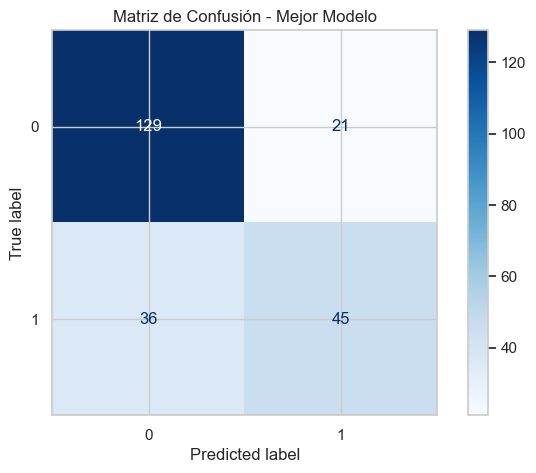

In [34]:
y_true = test_data[label]
y_pred = predictor.predict(test_data, model=best_model)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusión - Mejor Modelo")
plt.show()

- **Clase 0 (no diabetes):** 129 verdaderos negativos, 21 falsos positivos.  
- **Clase 1 (diabetes):** 45 verdaderos positivos, 36 falsos negativos.  
- El modelo clasifica mejor a los pacientes **sin diabetes**, pero pierde sensibilidad en detectar casos positivos.  


### Métricas adicionales

In [35]:
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.7818    0.8600    0.8190       150
           1     0.6818    0.5556    0.6122        81

    accuracy                         0.7532       231
   macro avg     0.7318    0.7078    0.7156       231
weighted avg     0.7468    0.7532    0.7465       231



- **Precisión (Clase 1):** 0.68 → de cada 10 predicciones positivas, ~7 son correctas.  
- **Recall (Clase 1):** 0.56 → el modelo detecta solo un poco más de la mitad de los pacientes con diabetes.  
- **F1-score (Clase 1):** 0.61 → equilibrio moderado entre precisión y recall.  
- **Macro promedio:** 0.72 (precision), 0.71 (recall), 0.72 (F1).  
- Esto refleja que el dataset está desbalanceado y el modelo tiende a favorecer la clase negativa.  


### Curva ROC y AUC

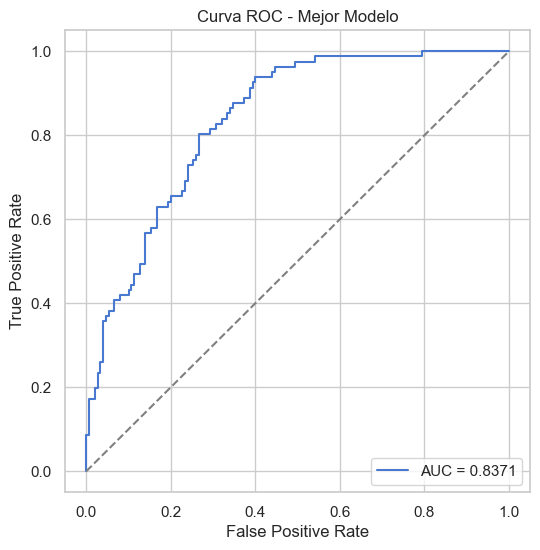

In [ ]:
y_proba = predictor.predict_proba(test_data, model=best_model)[1]  
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
auc_score = roc_auc_score(y_true, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Mejor Modelo")
plt.legend(loc="lower right")
plt.show()

- El **AUC = 0.837** indica buena capacidad discriminativa global entre clases.  
- El modelo es capaz de separar adecuadamente positivos y negativos al variar el umbral de decisión.  
- Sin embargo, el recall relativamente bajo sugiere que, en aplicaciones clínicas, se debería ajustar el umbral de predicción para priorizar la detección de casos positivos.  


- AutoGluon logró un **mejor desempeño que la regresión logística base**, pero el **trade-off entre precisión y recall** debe considerarse.  
- En salud, **minimizar falsos negativos**  es prioritario, incluso a costa de aumentar falsos positivos.  
- Ajustar el umbral de decisión o aplicar técnicas de balanceo de clases podría mejorar el rendimiento en la detección de diabetes.

## Reflexión

El uso de AutoGluon y AutoML permitió entrenar y comparar múltiples modelos de clasificación de manera rápida y automatizada, obteniendo un ensamble como mejor resultado sin necesidad de programar cada algoritmo desde cero. Esta capacidad ofrece una ventaja importante siendo esta el ahorro de tiempo que permte realizar una exploración sistemática de modelos y obtener desempeños competitivos sin necesidad de hiperajustes manuales extensivos.  

Sin embargo el proceso funciona como una caja negra en la cual se pierde parte del control sobre las decisiones de modelado y coimplica la interpretabilidad de los resultados. Además, el tiempo de cómputo puede ser alto al usar presets de máxima calidad.  

En este problema de predicción de diabetes, métricas como la precisión global son útiles, pero el recall y el F1-score de la clase positiva son más eficientes, ya que la prioridad clínica es minimizar falsos negativos. El **AUC-ROC** también es valioso para evaluar la capacidad discriminativa del modelo independientemente del umbral de decisión.  

Al aplicar AutoML en salud, deben tomarse precauciones éticas y prácticas como:  
- Validar los resultados con expertos clínicos.  
- Evitar depender únicamente de métricas globales.  
- Considerar la importancia de la interpretabilidad y la transparencia de los modelos.  
- Usar estos sistemas como apoyo a la decisión, no como reemplazo del juicio médico.  

En comparación con la construcción manual de un modelo, la experiencia con AutoGluon muestra que AutoML acelera el proceso exploratorio y logra modelos competitivos, pero el enfoque manual ofrece mayor control, comprensión del funcionamiento interno y capacidad de justificar decisiones. En este caso, el mejor balance surge al*combinar ambas aproximaciones como  usar AutoML para exploración inicial y ensamble, y complementar con modelos manuales más interpretables para aplicaciones críticas como la salud.